In [83]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pyplot

In [84]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
data = scada_data[['dtTimeStamp','WindSpeedMean','WindDirectionMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindSpeedMean','WindDirectionMean']][0:2000]
print(data.tail(100))

                     WindSpeedMean  WindDirectionMean
dtTimeStamp                                          
2019-08-14 04:40:00       3.011111         132.811111
2019-08-14 04:50:00       2.996296         134.166667
2019-08-14 05:00:00       2.981481         135.488889
2019-08-14 05:10:00       2.925926         138.229630
2019-08-14 05:20:00       2.692593         140.996296
...                            ...                ...
2019-08-14 20:30:00       4.744444         192.011111
2019-08-14 20:40:00       4.588889         190.214815
2019-08-14 20:50:00       4.725926         189.303704
2019-08-14 21:00:00       5.211111         193.203704
2019-08-14 21:10:00       5.344444         195.440741

[100 rows x 2 columns]


In [85]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt

def get_predictions(data, column_name):
    X = data[[column_name]]
    size = int(len(X) * 0.1)
    train, test = X[0:size], X[size:len(X)]
    history = train
    predictions = pd.DataFrame(index=test.index, columns=[column_name])
    for i, row in test.iterrows():
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0].flatten()[0]
        predictions.loc[i][column_name] = yhat
        history.loc[i] = row[column_name]

    return predictions

In [114]:
import os
import sys

new_path = r'C:\Users\hanna\Documents\GitHub\dissertation'
sys.path.append(new_path)

from api.noise_campaign.histogram import Histogram

#h = Histogram(3, 12, 1, 12)
h = Histogram(3.5, 6, 2, 6)
wind_speed_bins = h.get_wind_speed_bins()
wind_direction_bins = h.get_wind_direction_bins()

In [115]:
wind_speed_bins

{3.5: [2.5, 4.5],
 5.5: [4.5, 6.5],
 7.5: [6.5, 8.5],
 9.5: [8.5, 10.5],
 11.5: [10.5, 12.5],
 13.5: [12.5, 14.5]}

In [116]:
wind_direction_bins

{0.0: [-30.0, 30.0],
 60.0: [30.0, 90.0],
 120.0: [90.0, 150.0],
 180.0: [150.0, 210.0],
 240.0: [210.0, 270.0],
 300.0: [270.0, 330.0]}

In [87]:
data["SpeedBin"] = data['WindSpeedMean'].apply(h.get_wind_speed_bin)
#data["DirectionBin"] = data['WindDirectionMean'].apply(h.get_wind_direction_bin)

data.dropna(inplace=True)

pred = get_predictions(data, "SpeedBin")

pred['SpeedBin'] = pred['SpeedBin'].apply(round)

Text(0.5, 1.0, 'Real vs Predictions')

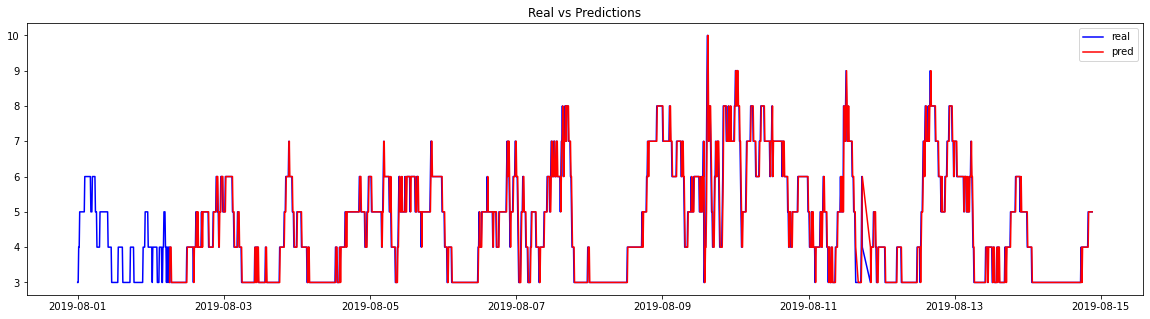

In [88]:
import matplotlib.pyplot as plt
    
plt.figure(figsize=(20,5))
plt.plot(data["SpeedBin"], color='blue', label='real')
plt.plot(pred["SpeedBin"].apply(round), color='red', label='pred')
plt.legend(loc='best')
plt.title('Real vs Predictions')

In [89]:
def map_direction_bins(b):
    b_dict = {0.0: 1, 30.0: 2, 60.0: 3, 90.0: 4, 120.0: 5, 150.0: 6, 180.0: 7, 210.0: 8, 240.0: 9, 270.0: 10, 300.0: 11, 330.0: 12}
    #b_dict = {0.0: 1, 60.0: 2, 120.0: 3, 180.0: 4, 240.0: 5, 300.0: 6}
    return b_dict[b]



data["DirectionBin"] = data['WindDirectionMean'].apply(h.get_wind_direction_bin).apply(map_direction_bins)

data.dropna(inplace=True)

pred_2 = get_predictions(data, "DirectionBin")


In [90]:
def get_nearest_bin(b, bin_list):
    differences = {x:abs(b-x) for x in bin_list.values()}

    return min(differences, key=differences.get)

In [91]:
comp_3 = pd.DataFrame()
b_dict = {0.0: 1, 30.0: 2, 60.0: 3, 90.0: 4, 120.0: 5, 150.0: 6, 180.0: 7, 210.0: 8, 240.0: 9, 270.0: 10, 300.0: 11, 330.0: 12}
#b_dict = {0.0: 1, 60.0: 2, 120.0: 3, 180.0: 4, 240.0: 5, 300.0: 6}

comp_3['SpeedBin'] = data['SpeedBin']
comp_3['DirectionBin'] = data['DirectionBin']
comp_3['DirectionBinMapped'] = data['DirectionBin']
comp_3['PredictedSpeedBin'] = pred["SpeedBin"] 
comp_3['PredictedDirectionBinRaw'] = pred_2["DirectionBin"]
comp_3['PredictedDirectionBin'] = pred_2["DirectionBin"].apply(get_nearest_bin, args=(b_dict,))
#d)

comp_3.dropna(inplace=True)
comp_3['SpeedBinEqual'] = comp_3['SpeedBin'] == comp_3["PredictedSpeedBin"]
comp_3['DirectionBinEqual'] = comp_3['DirectionBin'] == comp_3["PredictedDirectionBin"]

comp_3['SpeedBinDifference'] = comp_3["PredictedSpeedBin"] - comp_3['SpeedBin']
comp_3['DirectionBinDifference'] = (comp_3['DirectionBin'] - comp_3["PredictedDirectionBin"])


comp_3.query('DirectionBinEqual == False and SpeedBinEqual == False')


,SpeedBin,DirectionBin,DirectionBinMapped,PredictedSpeedBin,PredictedDirectionBinRaw,PredictedDirectionBin,SpeedBinEqual,DirectionBinEqual,SpeedBinDifference,DirectionBinDifference
dtTimeStamp,,,,,,,,,,
2019-08-02 06:10:00,4.0,11,11,3.0,10.0673,10.0,False,False,-1.0,1.0
2019-08-02 06:40:00,3.0,8,8,4.0,12.2721,12.0,False,False,1.0,-4.0
2019-08-02 14:00:00,3.0,11,11,4.0,12.0413,12.0,False,False,1.0,-1.0
2019-08-02 14:10:00,4.0,12,12,3.0,10.9605,11.0,False,False,-1.0,1.0
2019-08-02 15:10:00,4.0,12,12,5.0,11.0339,11.0,False,False,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-08-13 10:10:00,4.0,11,11,3.0,12.0288,12.0,False,False,-1.0,-1.0
2019-08-13 12:20:00,3.0,11,11,4.0,11.9875,12.0,False,False,1.0,-1.0
2019-08-13 13:00:00,3.0,12,12,4.0,11.0067,11.0,False,False,1.0,1.0


Text(0.5, 1.0, 'Real vs Predictions')

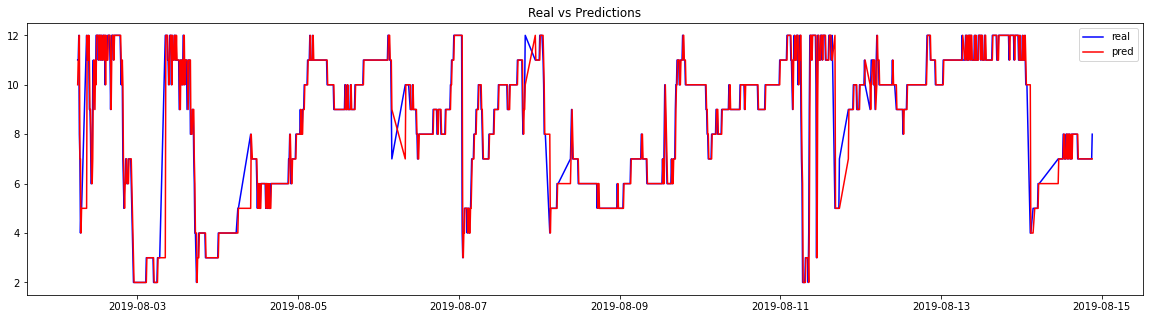

In [92]:
plt.figure(figsize=(20,5))
plt.plot(comp_3['DirectionBin'], color='blue', label='real')
plt.plot(comp_3['PredictedDirectionBin'], color='red', label='pred')
plt.legend(loc='best')
plt.title('Real vs Predictions')

In [93]:
wrong = comp_3.query('DirectionBinDifference != 0')
len(wrong) / comp_3.shape[0] * 100


21.556516368128477

In [94]:
wrong = comp_3.query('SpeedBinDifference != 0')
len(wrong) / comp_3.shape[0] * 100

21.98888202594194

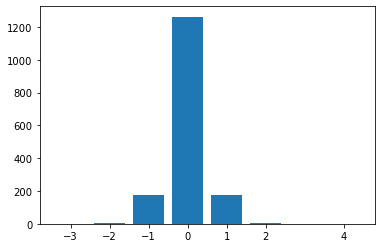

In [95]:
import numpy as np
labels, counts = np.unique(comp_3["SpeedBinDifference"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

<AxesSubplot:>

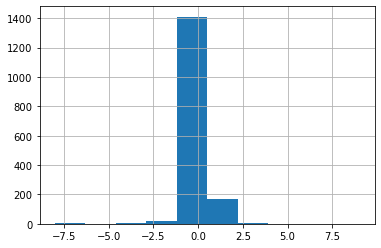

In [96]:
# labels, counts = np.unique(comp_3["DirectionBinDifference"], return_counts=True)
# plt.bar(labels, counts, align='center')
# plt.gca().set_xticks(labels)
# plt.show()

comp_3["DirectionBinDifference"].hist()

In [97]:
wrong = comp_3.query('DirectionBinDifference != 0 or SpeedBinDifference != 0')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
38.23347745521927


In [98]:
from statistics import mean

print(mean(comp_3["DirectionBinDifference"]))

print(mean(comp_3["SpeedBinDifference"]))

print(max(comp_3["SpeedBinDifference"]))

print(max(comp_3["DirectionBinDifference"]))

print(min(comp_3["SpeedBinDifference"]))

print(min(comp_3["DirectionBinDifference"]))

-0.0006176652254478073
-0.0012353304508956147
4.0
9.0
-3.0
-8.0


In [99]:
wrong = comp_3.query('DirectionBinEqual == False and SpeedBinEqual == False')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
5.311920938851142


In [100]:
wrong = comp_3.query('DirectionBinEqual == False or SpeedBinEqual == False')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
38.23347745521927


In [118]:
wrong = comp_3.query('DirectionBinEqual == True and SpeedBinEqual == False')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)


Percentage of bins wrong:
16.676961087090795


In [102]:
wrong = comp_3.query('SpeedBinEqual == False')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
21.98888202594194


In [103]:
from sklearn.metrics import mean_squared_error

print("\nMSE for direction")
print(mean_squared_error(comp_3['PredictedDirectionBin'], comp_3['DirectionBin']))

print("\nMSE for speed")
print(mean_squared_error(comp_3['PredictedSpeedBin'], comp_3['SpeedBin']))


MSE for direction
0.5898702903026559

MSE for speed
0.24706609017912293


In [104]:
wrong = comp_3.query('DirectionBinDifference in [-1,1] or SpeedBinDifference in [-1,1]')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
35.268684373069796


In [105]:
wrong = comp_3.query('DirectionBinDifference in [-1,1]')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
18.097591105620754


In [106]:
wrong = comp_3.query('SpeedBinDifference in [-1,1]')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
21.43298332303891


In [111]:
wrong = comp_3.query('DirectionBinDifference in [-1,1] or SpeedBinDifference in [-1,1]')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
35.268684373069796


In [108]:
wrong = comp_3.query('DirectionBinDifference not in [-1,1,0]')

error = len(wrong) / comp_3.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
3.4589252625077207


In [109]:
np.std(comp_3["DirectionBinDifference"])

0.7680298879551012

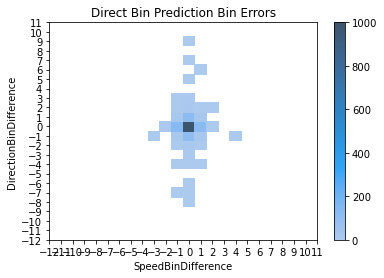

In [110]:
import seaborn as sns
x = comp_3['SpeedBinDifference']
y = comp_3['DirectionBinDifference']

g = sns.histplot(comp_3, x="SpeedBinDifference", y="DirectionBinDifference", discrete=True, cbar=True)
g.set_xticks(range(-12,12))#
g.set_yticks(range(-12,12))# <--- set the ticks first
g.set_title('Direct Bin Prediction Bin Errors')

fig = g.get_figure()
fig.savefig("direct_bin_errors.png")